In [1]:
from fastai.vision.all import *
import re
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import torch
from fastai.callback.tracker import EarlyStoppingCallback

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Sat Aug 30 18:45:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
torch.cuda.is_available()

True

In [5]:
# path = Path('./data/pneumothorax/png_images')
path = Path('/content/drive/MyDrive/VIU/TFM/data/pneumothorax/png_images')

# Filtramos solo los archivos de entrenamiento
files = [f for f in path.ls() if '_train_' in f.name]

In [6]:
def label_func(fname):
    fname = str(fname)
    match = re.search(r'_(\d)_\.png$', fname)
    return int(match.group(1)) if match else 0

In [7]:
from fastai.vision.all import PILImage
from PIL import Image, ImageDraw

def circle_mask_image_open(fn, thickness_ratio=0.1, radius_extra=100):
    """
    Dibuja un borde circular negro sólido alrededor de la imagen.
    radius_extra: número de píxeles que expanden el círculo más allá de los bordes.
    """
    img = Image.open(fn).convert("RGB")
    w, h = img.size
    thickness = int(min(w, h) * thickness_ratio)
    draw = ImageDraw.Draw(img)

    draw.ellipse([-thickness//2 - radius_extra,
                  -thickness//2 - radius_extra,
                  w + thickness//2 + radius_extra,
                  h + thickness//2 + radius_extra],
                 outline=(0,0,0), width=thickness)

    return PILImage(img)


In [8]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Obtener etiquetas
labels = [label_func(str(f)) for f in files]

# Contar clases
label_counts = Counter(labels)
print("Frecuencia de clases:", label_counts)

# Crear pesos inversos (menos frecuentes = mayor peso)
class_weights = {cls: 1.0 / count for cls, count in label_counts.items()}
sample_weights = [class_weights[label] for label in labels]

Frecuencia de clases: Counter({0: 8296, 1: 2379})


In [9]:
from sklearn.model_selection import train_test_split
from fastai.data.transforms import FuncSplitter
from random import sample, shuffle, choices

In [10]:
# Separar por clase
positives = [f for f in files if label_func(f) == 1]
negatives = [f for f in files if label_func(f) == 0]

# Split por clase
pos_train, pos_valid = train_test_split(positives, test_size=0.2, random_state=42)
neg_train, neg_valid = train_test_split(negatives, test_size=0.2, random_state=42)

# neg_train_sampled = sample(neg_train, len(pos_train) + 2000)

# Aumentar positivos SOLO en entrenamiento
pos_train_aug = pos_train * 2  # o usar resampling

# Unir y mezclar
train_files = pos_train_aug + neg_train
valid_files = pos_valid + neg_valid

# Mezclar todo
shuffle(train_files)
shuffle(valid_files)

all_files = train_files + valid_files

total_instances = len(all_files)
print(f"Nuevo total de archivos: {total_instances}")

# Crear un splitter personalizado
def splitter(fnames):
    return [[all_files.index(f) for f in train_files],
            [all_files.index(f) for f in valid_files]]

item_tfms = Resize(512)

batch_tfms = aug_transforms(
    do_flip=False,
    max_rotate=6,
    max_zoom=1.1,
    max_warp=0.1,
    max_lighting=0.2,
    p_lighting=0.75
)

PILImage.create = lambda fn: circle_mask_image_open(fn, thickness_ratio=0.2)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda _: all_files,
    get_y=label_func,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Crear los dataloaders
dls = dblock.dataloaders(path, bs=16)
#dls.train.after_item.add(bias_tf)

Nuevo total de archivos: 12578


In [11]:
# total_pos = len(pos_train) + len(pos_valid)
total_pos = len(pos_train_aug) + len(pos_valid)
total_neg = len(neg_train) + len(neg_valid)
print(f"Positivos: {total_pos / total_instances}, Negativos: {total_neg / total_instances}")

Positivos: 0.3404356813483861, Negativos: 0.6595643186516139


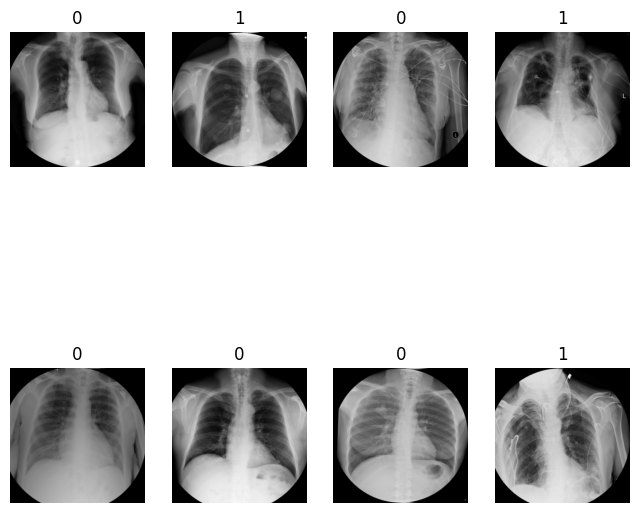

In [ ]:
dls.show_batch(max_n=9, figsize=(8,8))

### TODO:

* Usar FocalLoss
* Entrenar con 1024x1024

In [12]:
def F1Score(preds, targs):
    preds = torch.argmax(preds, dim=1)
    return f1_score(targs.cpu(), preds.cpu())

def Recall(preds, targs):
    preds = torch.argmax(preds, dim=1)
    return recall_score(targs.cpu(), preds.cpu())

metrics=[accuracy, Recall, F1Score]

In [13]:
pos_train_num = len(pos_train_aug)
neg_train_num = len(neg_train)
total_train_num = pos_train_num + neg_train_num

w_pos = total_train_num / (2 * pos_train_num)
w_neg = total_train_num / (2 * neg_train_num)

# En orden: [clase 0 (negativa), clase 1 (positiva)]
weights = [w_neg, w_pos]
print(weights)

[0.7867691380349608, 1.3717813977929585]


In [14]:
weights = torch.tensor(weights, device=default_device())
loss_func = CrossEntropyLossFlat(weight=weights)

In [17]:
learn = vision_learner(
    dls,
    # arch=models.vgg19_bn,
    arch=models.densenet121,
    metrics=metrics,
    loss_func=loss_func
).to_fp16()  # Usa half precision si tienes GPU

In [18]:
learn.freeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.555317,0.448337,0.790730,0.760157,0.588921,07:41


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

In [19]:
learn.export('./modelo_sin_esquinas_head.pkl')

In [20]:
learn.unfreeze()
learn.fit_one_cycle(
    3,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ]
)

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.663838,0.602044,0.768258,0.587052,0.498831,07:39
1,0.598431,0.870661,0.419944,0.905012,0.398409,07:36
2,0.500284,0.509412,0.766854,0.816221,0.584378,07:40


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 0 with F1Score value: 0.4988307572577231.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 2 with F1Score value: 0.5843781698705689.


In [21]:
learn.export('./modelo_sin_esquinas_3epochs.pkl')

In [22]:
learn.unfreeze()
learn.fit_one_cycle(
    3,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ]
)

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.577300,0.530965,0.829588,0.553870,0.544442,07:39
1,0.515697,0.576635,0.735487,0.822463,0.554782,07:43
2,0.513951,0.579971,0.694288,0.879472,0.537500,07:49


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: U

Better model found at epoch 0 with F1Score value: 0.5444420332060779.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 1 with F1Score value: 0.5547817536529398.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

In [23]:
learn.export('./modelo_sin_esquinas_6epochs.pkl')

In [24]:
learn.unfreeze()
learn.fit_one_cycle(
    3,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ]
)

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.605700,0.531179,0.708802,0.841689,0.541384,07:48
1,0.499481,0.522623,0.779026,0.822151,0.596874,07:56
2,0.507964,0.518933,0.732678,0.870983,0.565343,07:48


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 0 with F1Score value: 0.5413839855538116.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

Better model found at epoch 1 with F1Score value: 0.5968737487574232.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

In [25]:
learn.export('./modelo_sin_esquinas_9epochs.pkl')

In [ ]:
learn = load_learner('./modelo_densenet121_head_con_weigths_3epochs.pkl')

In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func
learn = learn.to_fp16()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    5,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ]
)

epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.594281,0.707146,0.456929,0.943606,0.420391,13:24
1,0.603052,0.584049,0.690075,0.657633,0.460818,08:16
2,0.540141,0.676138,0.495787,0.940102,0.438504,08:11
3,0.466608,0.590310,0.701311,0.918548,0.557018,08:37
4,0.477023,0.427579,0.795880,0.812092,0.615189,08:49


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 0 with F1Score value: 0.42039140539513337.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 1 with F1Score value: 0.4608183950880578.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 3 with F1Score value: 0.5570180299299858.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 4 with F1Score value: 0.6151888551095421.


In [ ]:
learn.export('./modelo_densenet121_head_con_weigths_8epochs.pkl')

In [ ]:
learn.fit_one_cycle(
    5,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ]
)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.522765,0.508603,0.823034,0.467095,0.496011,08:51
1,0.537617,0.633709,0.742977,0.845256,0.568253,08:52
2,0.512685,0.483467,0.796816,0.802283,0.611521,08:57
3,0.466986,0.421083,0.809925,0.813447,0.630058,08:52
4,0.443172,0.432903,0.805243,0.842911,0.635888,08:54


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 0 with F1Score value: 0.49601127129216976.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 1 with F1Score value: 0.5682525621058334.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 2 with F1Score value: 0.611521106002269.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 3 with F1Score value: 0.6300582688223136.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 4 with F1Score value: 0.6358881883336609.


In [ ]:
learn.export('./modelo_densenet121_head_con_weigths_13epochs.pkl')

In [ ]:
learn = load_learner('./modelo_densenet121_head_con_weigths_13epochs.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func
learn = learn.to_fp16()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    5,  # máximo de épocas
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ]
)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.488868,0.440727,0.818820,0.623533,0.574047,11:50
1,0.509811,0.450034,0.776217,0.819493,0.594414,07:56
2,0.513906,0.410392,0.816479,0.787765,0.629623,07:43
3,0.435410,0.411323,0.818820,0.821589,0.639051,07:46
4,0.415992,0.404561,0.819757,0.820510,0.644817,07:40


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 0 with F1Score value: 0.5740469268559152.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 1 with F1Score value: 0.5944140019487009.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 2 with F1Score value: 0.6296233105221867.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 3 with F1Score value: 0.6390514616225121.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 4 with F1Score value: 0.6448170247905869.


In [ ]:
learn.export('./modelo_densenet121_head_con_weigths_18epochs.pkl')

In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func
learn = learn.to_fp16()

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScal

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScal

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1660
           1       0.57      0.83      0.67       476

    accuracy                           0.82      2136
   macro avg       0.75      0.82      0.77      2136
weighted avg       0.86      0.82      0.83      2136



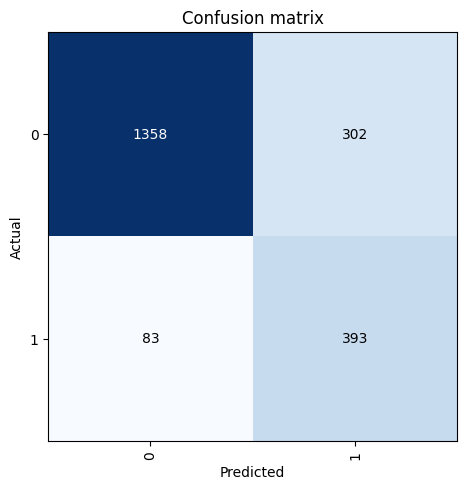

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

In [ ]:
learn = load_learner('./modelo_densenet121_head_con_weigths_18epochs.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback

learn.remove_cb(SaveModelCallback)
learn.remove_cb(EarlyStoppingCallback)
learn.dls = dls
learn.metrics = metrics
learn.loss_func = loss_func
learn = learn.to_fp16()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    3,  # máximo de épocas
    slice(3e-7, 3e-6),
    cbs=[
        EarlyStoppingCallback(
            monitor='F1Score',  # o 'valid_loss', según tu prioridad
            comp=np.greater,     # np.less si usas 'valid_loss'
            patience=4           # cuántas épocas esperar antes de detener
        ),
        SaveModelCallback(monitor='F1Score', comp=np.greater, fname='best_model')
    ]
)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,Recall,F1Score,time
0,0.420879,0.417436,0.802903,0.841573,0.627446,07:04
1,0.404073,0.426157,0.797285,0.852631,0.624809,07:04
2,0.440074,0.441982,0.783708,0.876422,0.617004,07:06


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Better model found at epoch 0 with F1Score value: 0.6274458974723345.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricW

### Evaluación en test

In [ ]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import os
import re

In [ ]:
learn = load_learner('./modelo_densenet121_head_con_weigths_18epochs.pkl')

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
# Función para extraer etiqueta desde el nombre del archivo
def get_label_from_filename(fname):
    match = re.search(r'_(\d)_\.png$', fname.name)
    return int(match.group(1)) if match else None

# Obtener imágenes de test
test_files = [f for f in path.iterdir() if f.is_file() and 'test' in f.name]
print("Cantidad de imagenes de test:", len(test_files))

# Etiquetas verdaderas
y_true = [get_label_from_filename(f) for f in test_files]

Cantidad de imagenes de test: 1372


In [ ]:
# Predicciones del modelo
y_pred = []
for f in test_files:
    pred_class, _, probs = learn.predict(f)
    y_pred.append(int(pred_class))  # Convertir a 0 o 1

In [ ]:
# Métricas sklearn
acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8229
Recall: 0.8069
F1 Score: 0.6582
Confusion Matrix:
[[895 187]
 [ 56 234]]


In [ ]:
# Mostrar algunas predicciones con probabilidad
for i in range(5):
    img = PILImage.create(test_files[i])
    pred_class, pred_idx, probs = learn.predict(img)
    print(f"{test_files[i].name} -> Pred: {pred_class}, Prob: {probs[pred_idx]:.4f}, True: {y_true[i]}")

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


922_test_0_.png -> Pred: 1, Prob: 0.5653, True: 0


915_test_0_.png -> Pred: 0, Prob: 0.6568, True: 0


925_test_0_.png -> Pred: 0, Prob: 0.9836, True: 0


918_test_0_.png -> Pred: 1, Prob: 0.7505, True: 0


914_test_1_.png -> Pred: 1, Prob: 0.8927, True: 1


### Hacer predicción

In [ ]:
img_path = path / '0_test_1_.png'
pred, pred_idx, probs = learn.predict(img_path)

print(f'Predicción: {pred}, Probabilidades: {probs}')

Predicción: 1, Probabilidades: tensor([0.0999, 0.9001])
